In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import meerkat as mk
import numpy as np
from glob import glob

In [55]:
# reveal new dataset's attribute and dimensions
# dp=mk.get("ngoa")["published_images"].lz[:2000]
# dp = mk.get("imagenette", version="160px").lz[:2000]
# dp = mk.get("imdb", registry="huggingface") 
# dp = mk.get("coco", version="2014").lz[:200] $ NOT WORKING YET 

,path (PandasSeriesColumn),noisy_labels_0 (PandasSeriesColumn),noisy_labels_1 (PandasSeriesColumn),noisy_labels_5 (PandasSeriesColumn),noisy_labels_25 (PandasSeriesColumn),noisy_labels_50 (PandasSeriesColumn),is_valid (PandasSeriesColumn),label_id (PandasSeriesColumn),label (PandasSeriesColumn),label_idx (PandasSeriesColumn),split (PandasSeriesColumn),img_path (PandasSeriesColumn),img (ImageColumn)
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False,n02979186,cassette player,482,train,train/n02979186/n02979186_9036.JPEG,
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False,n02979186,cassette player,482,train,train/n02979186/n02979186_11957.JPEG,

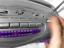
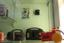

In [56]:
# dp.head(2)

In [4]:
# Set up your paths
DATA_DIR = '/Users/dakuowang/Desktop/FairytaleQA_Dataset/'
DOC_PATH = DATA_DIR + 'FairytaleQA_Dataset/split_by_origin'
SENTENCE_PATH = DATA_DIR + 'FairytaleQA_Dataset_Sentence_Split/split_by_origin'


In [5]:
DOC_PATH, SENTENCE_PATH

('/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin',
 '/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin')

## Document DataPanel
Load in the document data, from the 'FairytaleQA_Dataset/split_by_origin' directory.

In [6]:
# Create a Document DataPanel
doc_dp = mk.DataPanel({'path': glob(DOC_PATH + '/*/*.csv')}) # put in a column called 'path' with all the paths to the csv files

# Create some useful columns
doc_dp['source'] = doc_dp['path'].apply(lambda x: x.split('/')[-2]) # the source of the document e.g. "anderson-fairybook"
doc_dp['name'] = doc_dp['path'].apply(lambda x: x.split('/')[-1].split('.')[0]) # the name of the document e.g. "brave-tin-soldier-story.csv"
doc_dp['id'] = doc_dp['source'] + '/' + doc_dp['name'] # the id of the document e.g. "anderson-fairybook/brave-tin-soldier-story"

doc_dp.head(2) # note that the columns are "PandasSeriesColumns"

,path (PandasSeriesColumn),source (PandasSeriesColumn),name (PandasSeriesColumn),id (PandasSeriesColumn)
0,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/laotsze-story.csv,chinese-fairybook,laotsze-story,chinese-fairybook/laotsze-story
1,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/why-dog-and-cat-are-enemies-questions.csv,chinese-fairybook,why-dog-and-cat-are-enemies-questions,chinese-fairybook/why-dog-and-cat-are-enemies-questions


In [7]:
doc_dp['type'] = doc_dp['name'].str.split("-").str.get(-1) # the type of document among [story, questions] -- here we use pandas string methods directly on the column

In [11]:
# Next, we can load each of the CSV files in: each CSV will be loaded as a DataPanel
# We can store these DataPanels inside the doc_dp DataPanel i.e. it's nested (this is convenient here)
def load_doc_csv(row):
    """
    Loader for a single document csv file. This function takes a row of the doc_dp DataPanel
    and returns a DataPanel with the contents of the csv file.

    row: a row from the doc_dp DataPanel
    """
    # Load the csv file from disk as a DataPanel
    doc_data = mk.DataPanel.from_csv(row['path']) # access the 'path'
    # Just add a doc_id column, so we know which document this CSV came from
    doc_data['doc_id'] = [row['id']] * len(doc_data) # access the 'id'
    return doc_data

doc_dp['section_dp'] = doc_dp.map(load_doc_csv) # .map will run the function on each line of the DataPanel and put the result in a new column called 'section_dp'
doc_dp # you should see a DataPanel with 6 columns (path, source, name, id, type, section_dp) and 556 rows

,path (PandasSeriesColumn),source (PandasSeriesColumn),name (PandasSeriesColumn),id (PandasSeriesColumn),type (PandasSeriesColumn),section_dp (ListColumn)
0,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/laotsze-story.csv,chinese-fairybook,laotsze-story,chinese-fairybook/laotsze-story,story,"DataPanel(nrows: 5, ncols: 3)"
1,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/why-dog-and-cat-are-enemies-questions.csv,chinese-fairybook,why-dog-and-cat-are-enemies-questions,chinese-fairybook/why-dog-and-cat-are-enemies-questions,questions,"DataPanel(nrows: 20, ncols: 15)"
2,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/help-in-need-questions.csv,chinese-fairybook,help-in-need-questions,chinese-fairybook/help-in-need-questions,questions,"DataPanel(nrows: 28, ncols: 15)"
3,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/the-disowned-princess-questions.csv,chinese-fairybook,the-disowned-princess-questions,chinese-fairybook/the-disowned-princess-questions,questions,"DataPanel(nrows: 23, ncols: 15)"
4,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story.csv,chinese-fairybook,how-the-river-gods-wedding-was-broken-off-story,chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story,story,"DataPanel(nrows: 6, ncols: 3)"
...,...,...,...,...,...,...
551,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/native-american-fairybook/the-bird-lover-story.csv,native-american-fairybook,the-bird-lover-story,native-american-fairybook/the-bird-lover-story,story,"DataPanel(nrows: 17, ncols: 3)"
552,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/native-american-fairybook/the-celestial-sisters-story.csv,native-american-fairybook,the-celestial-sisters-story,native-american-fairybook/the-celestial-sisters-story,story,"DataPanel(nrows: 10, ncols: 3)"
553,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/native-american-fairybook/white-feather-and-the-six-giants-story.csv,native-american-fairybook,white-feather-and-the-six-giants-story,native-american-fairybook/white-feather-and-the-six-giants-story,story,"DataPanel(nrows: 14, ncols: 3)"
554,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/native-american-fairybook/the-enchanted-moccasins-story.csv,native-american-fairybook,the-enchanted-moccasins-story,native-american-fairybook/the-enchanted-moccasins-story,story,"DataPanel(nrows: 19, ncols: 3)"


In [12]:
# Split the doc_dp DataPanel into two DataPanels, one for stories and one for questions
story_doc_dp = doc_dp[doc_dp['type'] == 'story']
question_doc_dp = doc_dp[doc_dp['type'] == 'questions']
story_doc_dp.shape, question_doc_dp.shape

((276, 6), (276, 6))

In [13]:
story_doc_dp.head(2)

,path (PandasSeriesColumn),source (PandasSeriesColumn),name (PandasSeriesColumn),id (PandasSeriesColumn),type (PandasSeriesColumn),section_dp (ListColumn)
0,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/laotsze-story.csv,chinese-fairybook,laotsze-story,chinese-fairybook/laotsze-story,story,"DataPanel(nrows: 5, ncols: 3)"
1,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset/split_by_origin/chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story.csv,chinese-fairybook,how-the-river-gods-wedding-was-broken-off-story,chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story,story,"DataPanel(nrows: 6, ncols: 3)"


In [14]:
# Magic: we can now access all the DataPanels inside story_doc_dp, concatenate them and get out a single DataPanel
story_doc_sections_dp = mk.concat(story_doc_dp['section_dp'])
story_doc_sections_dp.head(2)

,section (PandasSeriesColumn),doc_id (PandasSeriesColumn),text (PandasSeriesColumn)
0,1,chinese-fairybook/laotsze-story,"Laotsze is really older than heaven and earth put together. He is the Yellow Lord or Ancient, who created this world together with the other four. At various times he has appeared on earth, under various names. His most celebrated incarnation, however, is that of Laotsze, ""The Old Child,"" which name he was given because he made his appearance on earth with white hair."
1,2,chinese-fairybook/laotsze-story,"He acquired all sorts of magic powers by means of which he extended his life-span. Once he hired a servant to do his bidding. He agreed to give him a hundred pieces of copper daily; yet he did not pay him, and finally he owed him seven million, two hundred thousand pieces of copper. Then he mounted a black steer and rode to the West. He wanted to take his servant along. But when they reached the Han-Gu pass, the servant refused to go further, and insisted on being paid. Yet Laotsze gave him nothing."


In [15]:
# Similarly, we can do this for the question DataPanels
try:
    # This doesn't work, because a couple of the question DataPanels have different columns
    question_doc_sections_dp = mk.concat(question_doc_dp['section_dp'])
except:
    # We can check which rows have different columns
    has_extra_column = np.where(question_doc_dp.map(lambda x: len(x['section_dp'].columns)) == 16)[0]
    print("These rows have an extra column, while all the others have 15 columns", has_extra_column) # 47, 109
    extra_column_name = set(question_doc_dp[47]['section_dp'].columns) - set(question_doc_dp[0]['section_dp'].columns)
    print("The extra column is called", extra_column_name) # called "comments"
    # We can fix this by dropping the extra column if it exists
    question_doc_dp['section_dp'] = question_doc_dp['section_dp'].map(lambda x: x.drop(extra_column_name, check_exists=False))
    # Now we can concatenate
    question_doc_sections_dp = mk.concat(question_doc_dp['section_dp'])
    
question_doc_sections_dp.head(2)

These rows have an extra column, while all the others have 15 columns [ 47 109]
The extra column is called {'comments'}


,answer2 (PandasSeriesColumn),cor_section (PandasSeriesColumn),answer3 (PandasSeriesColumn),doc_id (PandasSeriesColumn),question (PandasSeriesColumn),local-or-sum (PandasSeriesColumn),answer1 (PandasSeriesColumn),answer5 (PandasSeriesColumn),question_id (PandasSeriesColumn),attribute2 (PandasSeriesColumn),answer4 (PandasSeriesColumn),attribute1 (PandasSeriesColumn),ex-or-im1 (PandasSeriesColumn),answer6 (PandasSeriesColumn),ex-or-im2 (PandasSeriesColumn)
0,NaN,1,NaN,chinese-fairybook/why-dog-and-cat-are-enemies-questions,Why was it a lucky ring?,local,Whoever owned it always had enough to live on.,NaN,1,NaN,Whoever owned it always had enough to live on,causal relationship,explicit,NaN,explicit
1,They did not know whoever owned the ring would always have enough to live on.,1,NaN,chinese-fairybook/why-dog-and-cat-are-enemies-questions,Why did the man and his wife sell the ring for a small sum?,local,They did not know that it was a lucky ring.,They did not know it was a lucky ring,2,NaN,They did not know about the ring's power,causal relationship,implicit,NaN,implicit


In [16]:
# These are all the DataPanels we have so far, with their shapes
doc_dp.shape, story_doc_dp.shape, question_doc_dp.shape, story_doc_sections_dp.shape, question_doc_sections_dp.shape

((556, 6), (276, 6), (276, 6), (4071, 3), (10553, 15))

## Sentence DataPanel

In [17]:
# Create a Sentence DataPanel
sentence_dp = mk.DataPanel({'path': glob(SENTENCE_PATH + '/*/*.csv')}) # put in a column called 'path' with all the paths to the csv files

# Create some useful columns
sentence_dp['source'] = sentence_dp['path'].apply(lambda x: x.split('/')[-2]) # the source of the document e.g. "anderson-fairybook"
sentence_dp['name'] = sentence_dp['path'].apply(lambda x: x.split('/')[-1].split('.')[0]) # the name of the document e.g. "brave-tin-soldier-story.csv"
sentence_dp['id'] = sentence_dp['source'] + '/' + sentence_dp['name'] # the id of the document e.g. "anderson-fairybook/brave-tin-soldier-story"

sentence_dp.head(2) # note that the columns are "PandasSeriesColumns"

,path (PandasSeriesColumn),source (PandasSeriesColumn),name (PandasSeriesColumn),id (PandasSeriesColumn)
0,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/laotsze-story.csv,chinese-fairybook,laotsze-story,chinese-fairybook/laotsze-story
1,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story.csv,chinese-fairybook,how-the-river-gods-wedding-was-broken-off-story,chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story


In [18]:
sentence_dp['type'] = sentence_dp['name'].str.split("-").str.get(-1) # the type of document among [story, mrs] -- here we use pandas string methods directly on the column
sentence_dp['type'].unique()

array(['story', 'mrs'], dtype=object)

In [19]:
# Next, we can load each of the CSV files in: each CSV will be loaded as a DataPanel
# We can store these DataPanels inside the sentence_dp DataPanel i.e. it's nested (this is convenient here)
def load_sentence_csv(row):
    """
    Loader for a single sentence csv file. This function takes a row of the sentence_dp DataPanel
    and returns a DataPanel with the contents of the csv file.

    row: a row from the sentence_dp DataPanel
    """
    # Load the csv file from disk as a DataPanel
    sentence_data = mk.DataPanel.from_csv(row['path']) # access the 'path'
    # Just add a sentence_id column, so we know which document this CSV came from
    sentence_data['sentence_id'] = [row['id']] * len(sentence_data) # access the 'id'
    # Drop the `document_id` column, because we already have the `id` column
    sentence_data = sentence_data.drop('document_id')
    return sentence_data

sentence_dp['sentence_dp'] = sentence_dp.map(load_sentence_csv) # .map will run the function on each line of the DataPanel and put the result in a new column called 'sentence_dp'
sentence_dp # you should see a DataPanel with 6 columns (path, source, name, id, type, sentence_dp) and 278 rows

,path (PandasSeriesColumn),source (PandasSeriesColumn),name (PandasSeriesColumn),id (PandasSeriesColumn),type (PandasSeriesColumn),sentence_dp (ListColumn)
0,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/laotsze-story.csv,chinese-fairybook,laotsze-story,chinese-fairybook/laotsze-story,story,"DataPanel(nrows: 32, ncols: 2)"
1,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story.csv,chinese-fairybook,how-the-river-gods-wedding-was-broken-off-story,chinese-fairybook/how-the-river-gods-wedding-was-broken-off-story,story,"DataPanel(nrows: 45, ncols: 2)"
2,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/how-the-five-ancients-became-men-story.csv,chinese-fairybook,how-the-five-ancients-became-men-story,chinese-fairybook/how-the-five-ancients-became-men-story,story,"DataPanel(nrows: 46, ncols: 2)"
3,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/old-dschang-story.csv,chinese-fairybook,old-dschang-story,chinese-fairybook/old-dschang-story,story,"DataPanel(nrows: 89, ncols: 2)"
4,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/chinese-fairybook/how-molo-stole-the-lovely-rose-red-story.csv,chinese-fairybook,how-molo-stole-the-lovely-rose-red-story,chinese-fairybook/how-molo-stole-the-lovely-rose-red-story,story,"DataPanel(nrows: 72, ncols: 2)"
...,...,...,...,...,...,...
273,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/native-american-fairybook/the-winter-spirit-and-his-visitor-story.csv,native-american-fairybook,the-winter-spirit-and-his-visitor-story,native-american-fairybook/the-winter-spirit-and-his-visitor-story,story,"DataPanel(nrows: 26, ncols: 2)"
274,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/native-american-fairybook/the-bird-lover-story.csv,native-american-fairybook,the-bird-lover-story,native-american-fairybook/the-bird-lover-story,story,"DataPanel(nrows: 131, ncols: 2)"
275,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/native-american-fairybook/the-celestial-sisters-story.csv,native-american-fairybook,the-celestial-sisters-story,native-american-fairybook/the-celestial-sisters-story,story,"DataPanel(nrows: 115, ncols: 2)"
276,/Users/dakuowang/Desktop/FairytaleQA_Dataset/FairytaleQA_Dataset_Sentence_Split/split_by_origin/native-american-fairybook/white-feather-and-the-six-giants-story.csv,native-american-fairybook,white-feather-and-the-six-giants-story,native-american-fairybook/white-feather-and-the-six-giants-story,story,"DataPanel(nrows: 111, ncols: 2)"


In [20]:
# Split the sentence_dp DataPanel into two DataPanels, one for stories and one for mrs
story_sentence_dp = sentence_dp[sentence_dp['type'] == 'story']
mrs_sentence_dp = sentence_dp[sentence_dp['type'] == 'mrs']
story_sentence_dp.shape, mrs_sentence_dp.shape

((276, 6), (2, 6))

In [21]:
# Like before, we can now access all the DataPanels inside story_sentence_dp, concatenate them and get out a single DataPanel
story_sentence_sections_dp = mk.concat(story_sentence_dp['sentence_dp'].filter(lambda x: len(x) > 0)) # need to filter out the empty DataPanels
mrs_sentence_sections_dp = mk.concat(mrs_sentence_dp['sentence_dp'].filter(lambda x: len(x) > 0)) # need to filter out the empty DataPanels
sentence_sections_dp = mk.concat(sentence_dp['sentence_dp'].filter(lambda x: len(x) > 0)) # need to filter out the empty DataPanels

In [22]:
sentence_sections_dp.head(2)

,text (PandasSeriesColumn),sentence_id (PandasSeriesColumn)
0,Laotsze is really older than heaven and earth put together.,chinese-fairybook/laotsze-story
1,"He is the Yellow Lord or Ancient, who created this world together with the other four.",chinese-fairybook/laotsze-story


In [23]:
# These are all the DataPanels we have so far, with their shapes
sentence_dp.shape, story_sentence_dp.shape, mrs_sentence_dp.shape, story_sentence_sections_dp.shape, mrs_sentence_sections_dp.shape, sentence_sections_dp.shape

((278, 6), (276, 6), (2, 6), (25213, 2), (169, 2), (25382, 2))